# TP2 Apprentissage supervisé avec Python 

### JOYMANGUL Jensen
### MOISSON Matthieu
#### 13/01/18

## Import

In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan)

import pandas as pd



import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## I. Apprentissage supervisé : feature engineering et classification

### 1) Chargement des données et préparation

In [2]:
data = pd.read_csv('./parkinsons.csv', sep=';')
X = data.ix[:, 1:23].values
Y = data.ix[:, 23].values
name_col=data.columns[1:23]
labels = data.ix[:, 0].values

#### L'histogramme des malade et non malade

(195, 22)
Pourcentage de 0: 24.615385
Pourcentage de 1: 75.384615


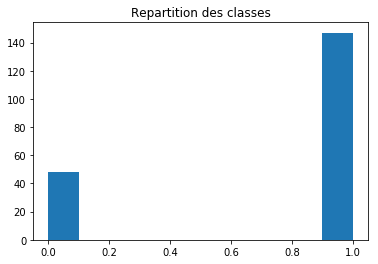

In [3]:
print(X.shape)
print("Pourcentage de 0: {0:3f}".format(100*sum(Y==0) / len(Y)))
print("Pourcentage de 1: {0:3f}".format(100*sum(Y==1) / len(Y)))

plt.hist(Y)
plt.title("Repartition des classes")
plt.show()

#### Test-Train

In [4]:
from sklearn.model_selection import train_test_split
X1, X2, Y1, Y2 = train_test_split(X, Y, test_size= 0.5, random_state=1)
print("Détail sur la table d'apprentissage {}".format(X1.shape))

Détail sur la table d'apprentissage (97, 22)


### 2) Apprentissage et évaluation de modèles
#### Construction des classifieurs

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

def classifieur(X1, Y1, X2, Y2):
    DT = DecisionTreeClassifier(random_state=1)
    DT.fit(X1, Y1)
    YDT = DT.predict(X2)
    print("Decision Tree")
    print(confusion_matrix(Y2, YDT))
    print("Accuracy score d'un DT: {0:.3f}".format(accuracy_score(Y2,YDT)))
    print("Precision score d'un DT: {0:.3f}".format(precision_score(Y2,YDT)))
    
    KNN = KNeighborsClassifier(n_neighbors=5)
    KNN.fit(X1, Y1)
    YKNN = KNN.predict(X2)
    print("K-plus-proche-voisin")
    print(confusion_matrix(Y2, YKNN))
    print("Accuracy score d'un KNN: {0:.3f}".format(accuracy_score(Y2,YKNN)))
    print("Precision score d'un KNN: {0:.3f}".format(precision_score(Y2,YKNN)))    

In [6]:
classifieur(X1, Y1, X2, Y2)

Decision Tree
[[17 10]
 [ 5 66]]
Accuracy score d'un DT: 0.847
Precision score d'un DT: 0.868
K-plus-proche-voisin
[[11 16]
 [ 4 67]]
Accuracy score d'un KNN: 0.796
Precision score d'un KNN: 0.807


### 3) Normalisation des variables continues
#### Normalisation

In [7]:
from sklearn.preprocessing import StandardScaler
standard_scalar = StandardScaler()
standard_scalar.fit(X1)
X1_scale = standard_scalar.transform(X1)
X2_scale =  standard_scalar.transform(X2)

#### Execution sur les données

In [8]:
classifieur(X1_scale, Y1, X2_scale, Y2)

Decision Tree
[[17 10]
 [ 5 66]]
Accuracy score d'un DT: 0.847
Precision score d'un DT: 0.868
K-plus-proche-voisin
[[13 14]
 [ 1 70]]
Accuracy score d'un KNN: 0.847
Precision score d'un KNN: 0.833


On peut voir que l'accuracy n'est pas améliorer pour l'arbre de décision. Cependant On peut voir que k-plus-proches-voisins (k=5) obtient un meilleurs résultat pour l'accuraccy et la précision.

### 4) Création de nouvelles variables caracteristiques par combinaisons linéaire des variables initiales

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X1_scale)
X1_pca = np.concatenate((X1_scale,pca.transform(X1_scale)), axis=1)
X2_pca = np.concatenate((X2_scale,pca.transform(X2_scale)), axis=1)

#### Execution sur les données

In [10]:
classifieur(X1_pca, Y1, X2_pca, Y2)

Decision Tree
[[19  8]
 [ 5 66]]
Accuracy score d'un DT: 0.867
Precision score d'un DT: 0.892
K-plus-proche-voisin
[[16 11]
 [ 0 71]]
Accuracy score d'un KNN: 0.888
Precision score d'un KNN: 0.866


L'ACP réalisé nous permet de gagner en précision et en accuracy sur les deux algorithmes d'apprentissage supervisé.

### 5) Sélection de variables

#### Affichage de l'histogramme des importances des variables avec la méthode Random Forest

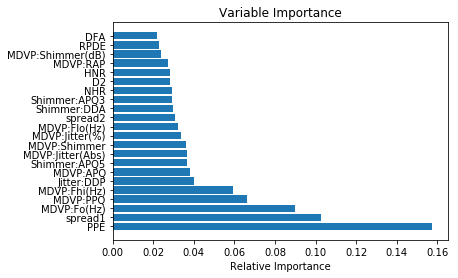

In [11]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X1_scale, Y1)

importances=clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features =name_col

# print(features[sorted_idx])
padding = np.arange(X1_scale.size/len(X1_scale)) + 0.5

plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

#### Selectioner la combinaison de variables la plus pertinente

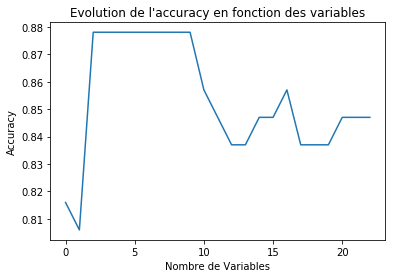

In [12]:
KNN=KNeighborsClassifier(n_neighbors=5)
scores=np.zeros(X1_scale.shape[1]+1)
for f in np.arange(0, X1_scale.shape[1]+1):
    X1_f = X1_scale[:,sorted_idx[:f+1]]
    X2_f = X2_scale[:,sorted_idx[:f+1]]
    KNN.fit(X1_f,Y1)
    YKNN=KNN.predict(X2_f)
    scores[f]=np.round(accuracy_score(Y2,YKNN),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

On peut voir qu'il y a un pic qui atteint presque 0.88. Ce premier pic permet de déterminer le nombre de variables à prendre. Il s'agit des 3 premieres. En ajoutant plus de variables nous ne pouvons esperer un meilleur résultat que avec trois. Au contraires nous risquons d'ajouter du bruits.

### Grid search KNN

In [13]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': [1,3,5,7,9,10]}
model = KNeighborsClassifier()
clf  = GridSearchCV(model, parameters,scoring='accuracy', cv=10)
grille = clf.fit(X1_pca, Y1)
print(grille.best_params_)
print(grille.best_score_)

YKNN_0 = grille.predict(X2_pca)
print("Accuracy score d'un Knn optimise: {0:.3f}".format(accuracy_score(Y2, YKNN_0)))

{'n_neighbors': 5}
0.927835051546
Accuracy score d'un Knn optimise: 0.888


Cela permet de selectionner le nombre k plus proche voisins le plus optimiser. Dans notre cas il faut les 5 k plus proche voisins.

## II. Apprentissage	supervisé	:	Données	hétérogènes	


### 1)
#### Chargement des données et préparation
* Importation

In [14]:
data_credit = pd.read_csv('./credit.data', sep='\t', header=-1 )

* Transformation et sepparation

In [15]:
X = data_credit.ix[:, :14].values
Y = data_credit.ix[:, 15].values

* Colonne numériques et catégorielles

In [16]:
col_num = [1, 2, 7, 10, 13, 14]
col_cat = [0, 3, 4, 5, 6, 8, 9, 11, 12]

* Supprimer les données manquantes

In [17]:
X_num = X[:, col_num]
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float)
Y_num = Y[~np.isnan(X_num).any(axis=1)]
X_num = X_num[~np.isnan(X_num).any(axis=1)]

* Analyser les propriété de nos données

In [18]:
print("Pourcentage de crédit positifs: {0:.3f}".format(100*sum(Y == '+') / len(Y)))
print("Pourcentage de crédit négatifs: {0:.3f}".format(100*sum(Y == '-') / len(Y)))

Pourcentage de crédit positifs: 44.331
Pourcentage de crédit négatifs: 55.669


* Binariser la sortie

In [19]:
Y_num[Y_num=='+'] = 1
Y_num[Y_num=='-'] = 0
Y_num = Y_num.astype(int)

#### Apprentisage et évolution de modèles

* import

In [20]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
import time

* Algorithmes d'apprentissage supervisé utilisés

In [21]:
clfs={
    "Decision Tree":DecisionTreeClassifier(random_state=1),
    "ID3":DecisionTreeClassifier(criterion="entropy"),
    "stump":DecisionTreeClassifier(random_state=1, max_depth=1),
    "MLP":MLPClassifier(hidden_layer_sizes=(20,10)),
    'KNN':KNeighborsClassifier(n_neighbors=10),
    "B50":BaggingClassifier(n_estimators=50),
    'RF':RandomForestClassifier(n_estimators=50),
    'AB':AdaBoostClassifier(n_estimators=50),
}

* Fonction d'évaluation des classifieurs

In [22]:
def run_classifiers(X, Y, clfs):
    kf=KFold(n_splits=5,shuffle=True,random_state=0)
    for i in clfs: 
        debut = time.time()
        clf = clfs[i]
        cv_acc = cross_val_score(clf, X, Y, cv=kf)
        fin = time.time()
        temps_execution = fin-debut
        print(i)
        print("Temps d'execution is : {0:.3f}".format(temps_execution))
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f}".format(i,np.mean(cv_acc),np.std(cv_acc))) 
        clf.fit(X,Y)
        yclf = clf.predict(X)
        print("Accuracy score d'un {0}: {1:.3f}".format(i, accuracy_score(Y,yclf)))
        print("Precision score d'un {0}: {1:.3f}".format(i, precision_score(Y,yclf)))
        print("AdaBoost avec 50 classifieurs")
        print(confusion_matrix(Y, yclf))
        print()


* Execution de notre fonction d'évaluation des classifieurs

In [23]:
run_classifiers(X_num, Y_num, clfs)

DT
Temps d'execution is : 0.029
Accuracy for DT is: 0.730 +/- 0.020
Accuracy score d'un DT: 1.000
Precision score d'un DT: 1.000
AdaBoost avec 50 classifieurs
[[367   0]
 [  0 299]]

ID3
Temps d'execution is : 0.026
Accuracy for ID3 is: 0.740 +/- 0.011
Accuracy score d'un ID3: 1.000
Precision score d'un ID3: 1.000
AdaBoost avec 50 classifieurs
[[367   0]
 [  0 299]]

stump
Temps d'execution is : 0.012
Accuracy for stump is: 0.743 +/- 0.042
Accuracy score d'un stump: 0.743
Precision score d'un stump: 0.864
AdaBoost avec 50 classifieurs
[[343  24]
 [147 152]]

MLP
Temps d'execution is : 0.471
Accuracy for MLP is: 0.671 +/- 0.039
Accuracy score d'un MLP: 0.619
Precision score d'un MLP: 0.674
AdaBoost avec 50 classifieurs
[[325  42]
 [212  87]]

KNN
Temps d'execution is : 0.023
Accuracy for KNN is: 0.692 +/- 0.020
Accuracy score d'un KNN: 0.737
Precision score d'un KNN: 0.830
AdaBoost avec 50 classifieurs
[[335  32]
 [143 156]]

B50
Temps d'execution is : 0.779
Accuracy for B50 is: 0.770 +

Nous pouvons voir que la prédiction est déjà très bonne pour certains classifieur. Cependant d'autres sont à améliorer. Attention au risque de suraprentissage.

#### Normalisation des variables continues
* Normalisation

In [24]:
from sklearn.preprocessing import StandardScaler
standard_scalar = StandardScaler()
standard_scalar.fit(X_num)
X_num_scale = standard_scalar.transform(X_num)

* Execution de run classifiers

In [25]:
run_classifiers(X_num_scale, Y_num, clfs)

DT
Temps d'execution is : 0.024
Accuracy for DT is: 0.730 +/- 0.020
Accuracy score d'un DT: 1.000
Precision score d'un DT: 1.000
AdaBoost avec 50 classifieurs
[[367   0]
 [  0 299]]

ID3
Temps d'execution is : 0.039
Accuracy for ID3 is: 0.749 +/- 0.019
Accuracy score d'un ID3: 1.000
Precision score d'un ID3: 1.000
AdaBoost avec 50 classifieurs
[[367   0]
 [  0 299]]

stump
Temps d'execution is : 0.013
Accuracy for stump is: 0.743 +/- 0.042
Accuracy score d'un stump: 0.743
Precision score d'un stump: 0.864
AdaBoost avec 50 classifieurs
[[343  24]
 [147 152]]

MLP
Temps d'execution is : 4.002
Accuracy for MLP is: 0.775 +/- 0.028
Accuracy score d'un MLP: 0.812
Precision score d'un MLP: 0.843
AdaBoost avec 50 classifieurs
[[327  40]
 [ 85 214]]

KNN
Temps d'execution is : 0.029
Accuracy for KNN is: 0.748 +/- 0.049
Accuracy score d'un KNN: 0.773
Precision score d'un KNN: 0.885
AdaBoost avec 50 classifieurs
[[345  22]
 [129 170]]

B50
Temps d'execution is : 0.875
Accuracy for B50 is: 0.782 +

On peut remarqué que les résultats sont dans l'ensemble améliorer.
Toutefois sur certaint algorithme comme dans le premier exercice la normalisation n'entraine pas de changement. 

### 2)
#### Traitement de données manquantes

* Import

In [26]:
from sklearn.preprocessing import Imputer, OneHotEncoder

* Pour les variables catégorielles

In [27]:
X_cat = np.copy(X[:,col_cat])
for col_id in range(len(col_cat)):
    unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True)
    X_cat[:, col_id] = val_idx 

imp_cat = Imputer(missing_values=0, strategy='most_frequent') 
X_cat[:, range(5)] = imp_cat.fit_transform(X_cat[:, range(5)])

* Pour les variables numériques

In [28]:
X_num = np.copy(X[:, col_num]) 
X_num[X_num == '?'] = np.nan 
X_num = X_num.astype(float)

imp_num = Imputer(missing_values=np.nan, strategy='mean')
X_num = imp_num.fit_transform(X_num)


Y_num_bis = Y[~np.isnan(X_num).any(axis=1)]
Y_num_bis[Y_num_bis=='+'] = 1
Y_num_bis[Y_num_bis=='-'] = 0
Y_num_bis = Y_num_bis.astype(int)

#### Traitement de variables catégorielles

In [29]:
X_cat_bin = OneHotEncoder().fit_transform(X_cat).toarray()

#### Construction de votre jeu de données

In [30]:
print(X_num.shape)
print(X_cat_bin.shape)
X_concat = np.concatenate([X_num,X_cat_bin],axis=1)
print(X_concat.shape)

(688, 6)
(688, 40)
(688, 46)


#### Evaluation de notre nouveau jeu de donné

In [31]:
run_classifiers(X_concat, Y_num_bis, clfs)

DT
Temps d'execution is : 0.037
Accuracy for DT is: 0.811 +/- 0.049
Accuracy score d'un DT: 1.000
Precision score d'un DT: 1.000
AdaBoost avec 50 classifieurs
[[383   0]
 [  0 305]]

ID3
Temps d'execution is : 0.032
Accuracy for ID3 is: 0.824 +/- 0.013
Accuracy score d'un ID3: 1.000
Precision score d'un ID3: 1.000
AdaBoost avec 50 classifieurs
[[383   0]
 [  0 305]]

stump
Temps d'execution is : 0.014
Accuracy for stump is: 0.856 +/- 0.036
Accuracy score d'un stump: 0.856
Precision score d'un stump: 0.786
AdaBoost avec 50 classifieurs
[[306  77]
 [ 22 283]]

MLP
Temps d'execution is : 0.674
Accuracy for MLP is: 0.661 +/- 0.058
Accuracy score d'un MLP: 0.706
Precision score d'un MLP: 0.694
AdaBoost avec 50 classifieurs
[[302  81]
 [121 184]]

KNN
Temps d'execution is : 0.036
Accuracy for KNN is: 0.702 +/- 0.020
Accuracy score d'un KNN: 0.741
Precision score d'un KNN: 0.832
AdaBoost avec 50 classifieurs
[[351  32]
 [146 159]]

B50
Temps d'execution is : 1.320
Accuracy for B50 is: 0.866 +

## III. Apprentissage	supervisé	sur	des	données	textuelles	:	Feature	engineering	et	Classification

In [86]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD



## CountVectorizer

In [81]:
data_sms = pd.read_csv('./SMSSpamCollection.data', sep='\t', header=-1)
X_sms = data_sms.ix[:, 1].values
Y_sms = data_sms.ix[:, 0].values

Y_sms[Y_sms=='ham'] = 1
Y_sms[Y_sms=='spam'] = 0
Y_sms = Y_sms.astype(int)

In [99]:
cv = CountVectorizer(max_features=500, stop_words = 'english')
X_sms_classified = cv.fit_transform(X_sms)
run_classifiers(X_sms_classified, Y_sms, clfs)

DT
Temps d'execution is : 0.365
Accuracy for DT is: 0.962 +/- 0.003
Accuracy score d'un DT: 0.998
Precision score d'un DT: 0.998
AdaBoost avec 50 classifieurs
[[ 738    9]
 [   2 4823]]

ID3
Temps d'execution is : 0.399
Accuracy for ID3 is: 0.960 +/- 0.004
Accuracy score d'un ID3: 0.998
Precision score d'un ID3: 0.998
AdaBoost avec 50 classifieurs
[[ 738    9]
 [   2 4823]]

stump
Temps d'execution is : 0.018
Accuracy for stump is: 0.891 +/- 0.011
Accuracy score d'un stump: 0.891
Precision score d'un stump: 0.890
AdaBoost avec 50 classifieurs
[[ 152  595]
 [  13 4812]]

MLP
Temps d'execution is : 12.817
Accuracy for MLP is: 0.980 +/- 0.002
Accuracy score d'un MLP: 0.998
Precision score d'un MLP: 0.998
AdaBoost avec 50 classifieurs
[[ 736   11]
 [   0 4825]]

KNN
Temps d'execution is : 0.751
Accuracy for KNN is: 0.919 +/- 0.013
Accuracy score d'un KNN: 0.935
Precision score d'un KNN: 0.931
AdaBoost avec 50 classifieurs
[[ 388  359]
 [   1 4824]]

B50
Temps d'execution is : 13.953
Accura

On peut constater les algorithme sont déjà très performant. 

## Tf–idf	term	weighting

In [90]:
transformer = TfidfTransformer()
print(X_sms_classified.shape)
X_sms_transformed = transformer.fit_transform(X_sms_classified)
run_classifiers(X_sms_transformed, Y_sms, clfs)

(5572, 500)
DT
Temps d'execution is : 0.843
Accuracy for DT is: 0.966 +/- 0.006
Accuracy score d'un DT: 0.998
Precision score d'un DT: 0.998
AdaBoost avec 50 classifieurs
[[ 738    9]
 [   2 4823]]

ID3
Temps d'execution is : 1.021
Accuracy for ID3 is: 0.966 +/- 0.002
Accuracy score d'un ID3: 0.998
Precision score d'un ID3: 0.998
AdaBoost avec 50 classifieurs
[[ 738    9]
 [   2 4823]]

stump
Temps d'execution is : 0.016
Accuracy for stump is: 0.891 +/- 0.011
Accuracy score d'un stump: 0.891
Precision score d'un stump: 0.890
AdaBoost avec 50 classifieurs
[[ 152  595]
 [  13 4812]]

MLP
Temps d'execution is : 16.863
Accuracy for MLP is: 0.979 +/- 0.002
Accuracy score d'un MLP: 0.998
Precision score d'un MLP: 0.998
AdaBoost avec 50 classifieurs
[[ 736   11]
 [   2 4823]]

KNN
Temps d'execution is : 0.714
Accuracy for KNN is: 0.914 +/- 0.010
Accuracy score d'un KNN: 0.934
Precision score d'un KNN: 0.931
AdaBoost avec 50 classifieurs
[[ 389  358]
 [   9 4816]]

B50
Temps d'execution is : 2

En fonction des algorithme cela peut s'améliorer. Cependant les algorithme qui était déjà bon ne vont pas être améliorer. Au contraire cela risque d'augmenter le temps de traitement.

## TruncatedSVD

In [98]:
truncated = TruncatedSVD(n_components=20)
X_sms_truncated = truncated.fit_transform(X_sms_transformed)

run_classifiers(X_sms_truncated, Y_sms, clfs)


DT
Temps d'execution is : 0.544
Accuracy for DT is: 0.958 +/- 0.006
Accuracy score d'un DT: 0.998
Precision score d'un DT: 0.998
AdaBoost avec 50 classifieurs
[[ 738    9]
 [   2 4823]]

ID3
Temps d'execution is : 0.537
Accuracy for ID3 is: 0.960 +/- 0.009
Accuracy score d'un ID3: 0.998
Precision score d'un ID3: 0.998
AdaBoost avec 50 classifieurs
[[ 738    9]
 [   2 4823]]

stump
Temps d'execution is : 0.053
Accuracy for stump is: 0.893 +/- 0.008
Accuracy score d'un stump: 0.893
Precision score d'un stump: 0.960
AdaBoost avec 50 classifieurs
[[ 565  182]
 [ 415 4410]]

MLP
Temps d'execution is : 15.359
Accuracy for MLP is: 0.964 +/- 0.007
Accuracy score d'un MLP: 0.974
Precision score d'un MLP: 0.982
AdaBoost avec 50 classifieurs
[[ 658   89]
 [  57 4768]]

KNN
Temps d'execution is : 1.032
Accuracy for KNN is: 0.966 +/- 0.006
Accuracy score d'un KNN: 0.973
Precision score d'un KNN: 0.982
AdaBoost avec 50 classifieurs
[[ 660   87]
 [  62 4763]]

B50
Temps d'execution is : 14.070
Accura

Les arbres de décisions ne sont pas améliorer. Leur temps est cependant légerement augmenté. 
D'autres algorithme sont même dégradé.